# LSTM modeling of TUH_SEZ EEG dataset

## Data Source

The TUH EEG Seizure Corpus (TUSZ): This corpus has manually EEG signals that have been carefully annotated data for seizures. For more information about this corpus, please refer to https://www.isip.piconepress.com/projects/tuh_eeg/html/downloads.shtml

## Prerequisites 
1. pre-process the TUSZ dataset (Relavent notebooks in the directory)
2. insert the pre-processed data into a SQL database
3. host the SQL database via SQLengine. This can be localhost or remote on RDS, etc.


In [274]:
# !git clone https://github.com/ylin00/seizurecast
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from seizurecast.postgresql import SQLengine
from seizurecast.models.parameters import LABEL_BKG, LABEL_PRE, LABEL_SEZ

def setlabel(pres, post, len_pos=300, len_pre=300, sec_gap=600):
  """convert pres and post timestamps to background and preseizure labels"""
  y = []
  for _, (pres, post) in enumerate(zip(pres, post)):
    if post > len_pos and pres > sec_gap + len_pre:
      y.append(LABEL_BKG)
    elif post > len_pos and pres > sec_gap:
      y.append(LABEL_PRE)
    else:
      y.append(LABEL_SEZ)
  return y

## Explore the table used in this notebook

### Preprocessed training set of TCP type 01 

In [308]:
pd.read_sql("select * from preprocessed_train_tcp01 where token='00010489_s005_t009' limit 1", SQLengine).head()


,index,ch0,ch1,ch2,ch3,ch4,ch5,ch6,ch7,token,timestamp,post,pres
0,3288,-12.152822,6.48019,0.180046,-1.797507,8.262441,1.689422,0.017289,-2.230887,00010489_s005_t009,12.84375,None,None


## Patient directory

In [280]:
pd.read_sql("select * from directory limit 10", SQLengine).head()

,index,path0,path1,path2,path3,path4,path5,path6,train_test,tcp_type,patient_group,patient,session,token,token_path
0,0,,Users,yanxlin,github,ids,tusz_1_5_2,edf,train,03_tcp_ar_a,104,00010418,s018_2014_06_01,00010418_s018_t008,/Users/yanxlin/github/ids/tusz_1_5_2/edf/train...
1,1,,Users,yanxlin,github,ids,tusz_1_5_2,edf,train,03_tcp_ar_a,104,00010418,s018_2014_06_01,00010418_s018_t009,/Users/yanxlin/github/ids/tusz_1_5_2/edf/train...
2,2,,Users,yanxlin,github,ids,tusz_1_5_2,edf,train,03_tcp_ar_a,104,00010418,s018_2014_06_01,00010418_s018_t001,/Users/yanxlin/github/ids/tusz_1_5_2/edf/train...
3,3,,Users,yanxlin,github,ids,tusz_1_5_2,edf,train,03_tcp_ar_a,104,00010418,s018_2014_06_01,00010418_s018_t000,/Users/yanxlin/github/ids/tusz_1_5_2/edf/train...
4,4,,Users,yanxlin,github,ids,tusz_1_5_2,edf,train,03_tcp_ar_a,104,00010418,s018_2014_06_01,00010418_s018_t002,/Users/yanxlin/github/ids/tusz_1_5_2/edf/train...


## Labels of seizure events from experts

In [288]:
[pd.read_sql(f"""
select * from seiz_bckg 
where label='{lbl}' and train_test='train'
""", SQLengine).to_sql(f'tmp_{lbl}_train', SQLengine, if_exists='replace') for lbl in ['bckg', 'seiz']]
print(f"""Number of token containing seizures = {pd.read_sql("select count(*) from tmp_seiz_train", SQLengine).to_numpy()[0,0]}""")
print(f"""Else = {pd.read_sql("select count(*) from tmp_bckg_train", SQLengine).to_numpy()[0,0]}""")
pd.read_sql("select * from tmp_seiz_train limit 3", SQLengine).head()

Number of token containing seizures = 2370
Else = 6967


,level_0,index,token,time_start,time_end,label,prob,train_test
0,0,36,00000492_s003_t000,6.2825,35.8875,seiz,1.0,train
1,1,39,00000492_s003_t001,33.1425,53.0000,seiz,1.0,train
2,2,42,00000492_s003_t002,9.7925,29.1250,seiz,1.0,train


In [293]:
# # Computing the duration of each token 
# pd.read_sql(
# """
# SELECT token, max(time_end) duration from tmp_seiz_train group by token limit 3
# """, SQLengine).head()

# Split Train Test patients

In [289]:
# randomly sample 80/20 on patient level
from sklearn.model_selection import train_test_split
patient_id = np.unique(pd.read_sql("select * from directory where train_test='train' and tcp_type='01_tcp_ar'", SQLengine).loc[:,'patient'])
patient_train, patient_test = train_test_split(patient_id, test_size=0.2, random_state=0)

print(f"Patient ID: {patient_train[0:3]} ..., Train:{patient_train.shape}, Test:{patient_test.shape}")

Patient ID: ['00000577' '00006103' '00007936'] ..., Train:(246,), Test:(62,)


In [290]:
# Create table patient_group, storing patient ID and their train/test association
pd.concat(
    [pd.DataFrame({'patient':patient_train}).assign(train_test='train'),
    pd.DataFrame({'patient':patient_test}).assign(train_test='test')]
          ).to_sql('patient_group', SQLengine, if_exists='replace')

In [291]:
# create table tmp_token_group storing Token and their train/test group
pd.read_sql("""
select A.train_test, B.token
from patient_group A
inner join directory B on A.patient=B.patient;
""",SQLengine).to_sql('tmp_token_group', SQLengine, if_exists='replace')

In [294]:
print("patient group \n", pd.read_sql("select * from tmp_token_group", SQLengine)[['train_test','token']].groupby('train_test').count())

patient group 
             token
train_test       
test          712
train        2974


## Load train/test dataset

In [93]:
# Threshold
# len_pos, len_pre, sec_gap = 300, 300, 600  # default
len_pos, len_pre, sec_gap = 30, 300, 0

# select train dataset
feature_table = 'preprocessed_train_tcp01'
dataset=[]
for i, group in enumerate(['train', 'test']):
  dataset.append(pd.read_sql(f"""
  (
    select *
    from {feature_table} A
    where A.token in (
      select B.token from tmp_token_group B where B.train_test='{group}'
    ) and (
      A.pres<{sec_gap + len_pre}
      and {sec_gap}<A.pres
      and A.post>{len_pos}
    ) 
    limit 10000
  )

  union

  (
    select *
    from {feature_table} A
    where A.token in (
      select B.token from tmp_token_group B where B.train_test='{group}' 
    ) and (
      {sec_gap + len_pre}<A.pres
      and A.post>{len_pos}
    )
    limit 10000
  );
  """, SQLengine))
print(f"Size of Tran set = {dataset[0].shape}; \nSize of Test set = {dataset[1].shape}")

Size of Tran set = (12040, 13); 
Size of Test set = (3428, 13)


In [94]:

print('binary clf data \n',
dataset[0]\
.assign(label = lambda x: setlabel(x.pres, x.post, len_pos=len_pos, len_pre=len_pre, sec_gap=sec_gap))\
.groupby(['label'])\
.count())

binary clf data 
        index    ch0    ch1    ch2    ch3    ch4    ch5    ch6    ch7  token  \
label                                                                         
bckg   10000  10000  10000  10000  10000  10000  10000  10000  10000  10000   
pres    2040   2040   2040   2040   2040   2040   2040   2040   2040   2040   

       timestamp   post   pres  
label                           
bckg       10000  10000  10000  
pres        2040   2040   2040  


# Training

## Data Prep

In [203]:
def chop_signal(long_vec, width=256, stepsize=64):
    """Chop a long long vector into 2D numpy array of width, consecutive rows will have certain overlap
    
    Args:
        long_vec: long vector
        width(int): width of the result. Must no greater than length of long_vec 
        overlap(int): Must less than width. 
    """
    long_vec = np.hstack([long_vec[i:i+width] for i in np.arange(0, len(long_vec)-width, stepsize)])
    return np.reshape(long_vec[0:(len(long_vec)//width*width)], [-1, width])

chop_signal([1, 2, 3, 4, 5, 6, 7, 8], width=4, stepsize=1)

array([[1, 2, 3, 4],
       [3, 4, 5, 6]])

In [226]:
def get_dataset(df):
    df = df\
    .assign(label = lambda x: setlabel(x.pres, x.post, len_pos=len_pos, len_pre=len_pre, sec_gap=sec_gap))\
    .loc[lambda df: 
         df.token.isin(
             df\
                .groupby('token')\
                .count()\
                .reset_index()\
                .loc[lambda df: df['index'] > 256]\
                .loc[:, ['token']].to_numpy().flatten()
         )]\
    .loc[:,['token', 'label', 'ch0']]\
    .groupby(['token', 'label'])\
    .apply(lambda df: pd.DataFrame(chop_signal(df['ch0'].to_numpy(), 256, 64)))\
    .reset_index()
    return df.iloc[:, 3:259], df.iloc[:, 1]

dataset[0].pipe(get_dataset)[0].head()
# .loc[lambda df: df.groupby['token'].count().loc[:,'index']]

# .iloc[label=='pres'].head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-5416.341192,422.452514,25.003054,-0.084471,1.329349,0.086330,0.507676,-194.958594,0.572571,1.947392,...,-1.793234,-1.276645,-266.957839,0.409453,-5.652548,0.120854,0.006312,1.263053,-1.662148,2.305532
1,-4601.017235,-0.179022,12.600488,-48.456420,-51.710552,0.051018,18.448605,-0.756164,204.123160,-237.004586,...,-25.960476,-88.065364,219.104664,0.131065,57.266589,0.110951,13.100263,-188.949332,-0.178256,-0.019313
2,-0.150390,-3.809664,-0.188970,-0.333022,10.813831,0.023704,0.107324,0.265764,-0.487808,-0.149869,...,0.315246,0.152372,-1.831806,-0.250632,0.236453,1.466546,-2.615175,-278.921723,0.830645,0.107084
3,12.906474,0.116943,0.557850,-24.393317,0.262949,0.296430,-0.302976,62.080365,-0.325197,2.078073,...,1.220558,-1.366585,14.458503,-628.810425,490.810950,-83.830397,5.549310,-0.131032,1.232116,-0.531051
4,-347.631857,19.444096,0.086547,-99.701081,-1.751341,0.334110,4.648541,615.137959,25.915832,90.116549,...,-5.874777,10.438763,23.960211,-1.982237,0.263122,-277.154723,0.302948,-342.908712,-408.274742,-53.780103


### Convert dataframe to numpy array

In [250]:
train_X, train_y = dataset[0].pipe(get_dataset)
test_X, test_y = dataset[1].pipe(get_dataset)

train_X, test_X = [x.to_numpy()[:, :, np.newaxis] for x in [train_X, test_X]]  # new feature axis
train_y, test_y = [x.to_numpy() for x in [train_y, test_y]]

# binarize
test_y = np.array([int(y==LABEL_PRE) for y in test_y])[:,np.newaxis]
train_y = np.array([int(y==LABEL_PRE) for y in train_y])[:,np.newaxis]

print(f'shape of train X = {train_X.shape}, test X = {test_X.shape}')

shape of train X = (121, 256, 1), test X = (35, 256, 1)


data contain a lot of spikes


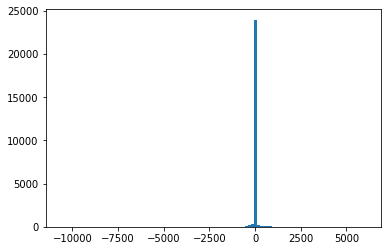

In [251]:
print("data contain a lot of spikes")
# np.histogram(train_X[1:1000,:].flatten())
# for features,label in train_ds.batch(1).take(10):
#   print(np.histogram(features.numpy().flatten()))
_ = plt.hist(train_X[1:100,:].flatten(), bins = 101)

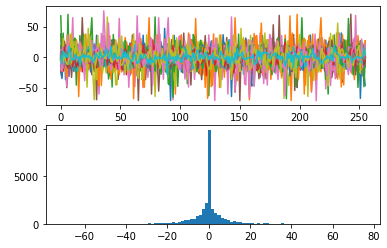

In [252]:
def get_median_filtered(signal, threshold=100):
  """By Bugra"""
  signal = signal.copy()
  difference = np.abs(signal - np.median(signal))
  median_difference = np.median(difference)
  if median_difference == 0:
      s = 0
  else:
      s = difference / float(median_difference)
  mask = s > threshold
  signal[mask] = np.median(signal)
  # if over 10% of data are spikes. return zeros
  if type(mask) is not bool and np.sum(mask) > 0.1 * len(mask):
    return np.zeros(signal.shape)
  return signal

train_X = np.array([get_median_filtered(signal, 8) for signal in train_X])
test_X = np.array([get_median_filtered(signal, 8) for signal in test_X])

_, axs = plt.subplots(2,1)
np.random.seed(0)
for signal in train_X[np.random.choice(train_X.shape[0], 100, replace=False),:]:
    axs[0].plot(signal)

_ = axs[1].hist(train_X[1:100,:].flatten(), bins = 101)

After removing spikes, the majority of the features are within a range of -20 to 20 (micro Vol). Let's scale them by 1/50 and normalize them.

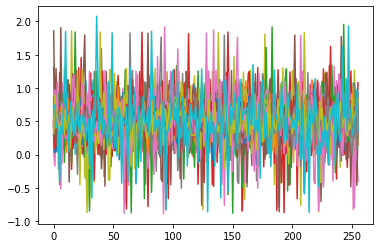

In [253]:
train_X = np.array([0.5 + (signal-np.mean(signal))/50 for signal in train_X ])
test_X = np.array([0.5 + (signal-np.mean(signal))/50 for signal in test_X ])
for signal in train_X[np.random.choice(train_X.shape[0], 100, replace=False),:]:
    plt.plot(signal)

### Drop out weak channels 

In [254]:
masks = [i for i, signal in enumerate(train_X) if np.sum(np.abs(signal))>1e-3]
train_X = train_X[masks, :, :]
train_y = train_y[masks, :]
masks = [i for i, signal in enumerate(test_X) if np.sum(np.abs(signal))>1e-3]
test_X = test_X[masks, :, :]
test_y = test_y[masks, :]

In [255]:
print("X shape = (samples, timesteps, nfeatures)")
print("y shape = (samples, nfeatures)")
print(f"shape trainX:{train_X.shape}")
print(f"shape trainy:{train_y.shape}")
print(f"shape testX:{test_X.shape}")
print(f"shape testy:{test_y.shape}")

X shape = (samples, timesteps, nfeatures)
y shape = (samples, nfeatures)
shape trainX:(121, 256, 1)
shape trainy:(121, 1)
shape testX:(35, 256, 1)
shape testy:(35, 1)


In [256]:
pd.DataFrame({
    'train': pd.Series(train_y.squeeze()).value_counts(),
    'test': pd.Series(test_y.squeeze()).value_counts()
})

,train,test
0,107,35.0
1,14,NaN


## Modeling

In [257]:
# Shuffling dataset
def unison_shuffled_copies(a, b):
  assert len(a) == len(b)
  p = np.random.permutation(len(a))
  return a[p], b[p]
np.random.seed(0)
train_X, train_y = unison_shuffled_copies(train_X, train_y)
test_X, test_y = unison_shuffled_copies(test_X, test_y)

In [262]:
# import tensorflow as tf
# import matplotlib.pyplot as plt

# def pack_row(*row):
#   label = row[0]
#   features = tf.stack(row[1:],1)
#   return features, label

# # Packed dataset
# BATCHSIZE = 100
# train_ds = tf.data.Dataset.from_tensor_slices((train_X.squeeze(), train_y.squeeze())).batch(BATCHSIZE).map(pack_row).unbatch()
# test_ds = tf.data.Dataset.from_tensor_slices((test_X, test_y)).batch(BATCHSIZE).map(pack_row).unbatch()

# for features,label in train_ds.batch(100).take(1):
#   print(features[0])
#   plt.hist(label.numpy().flatten(), bins = 101)


Check data balance

In [261]:
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout, Bidirectional

model = Sequential()
model.add(Input(shape=(256,1), name='Input'))
model.add(Bidirectional(LSTM(10, kernel_regularizer="l1", name='LSTM-1')))
model.add(Dropout(0.25, name='Dropout'))
model.add(Dense(1, activation='relu', name='Dense'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

print('start training')
model.fit(
        train_X, 
        train_y,
        validation_split=0.2, 
        batch_size=500, 
        epochs=3,
        verbose=1
    )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 20)                960       
_________________________________________________________________
Dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
Dense (Dense)                (None, 1)                 21        
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________
None
start training
Epoch 1/3
1/1 [==============================] - 1s 899ms/step - loss: 0.5208 - accuracy: 0.8750 - val_loss: 0.4370 - val_accuracy: 0.9200
Epoch 2/3
1/1 [==============================] - 0s 69ms/step - loss: 0.5073 - accuracy: 0.8750 - val_loss: 0.4350 - val_accuracy: 0.9200
Epoch 3/3
1/1 [==============================] - 0s 62ms/step - loss: 0.5430 - accuracy: 

/Users/yanxlin/opt/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


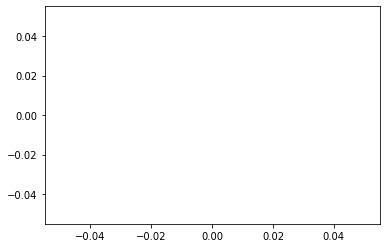

In [273]:
# Compare ROC curve
from sklearn.metrics import roc_curve

fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_y, model.predict(test_X).ravel())

plt.plot(fpr_keras, tpr_keras)